In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from collections import Counter, defaultdict
import warnings 
warnings.filterwarnings("ignore")

import MeCab
from gensim.models import word2vec
from gensim.models import Doc2Vec

In [2]:
with open("News_dataset.pickle", "rb") as data:
    df = pickle.load(data)
df = df.reset_index(drop=True)

df["Content_Parsed_1"] = df["Article"].str.replace("キーワードで気になるニュースを絞りこもう 「いいね」、フォローをしておすすめの記事をチェックしよう。 グノシーについて 公式SNS 関連サイト アプリをダウンロード グノシー | 情報を世界中の人に最適に届ける Copyright © Gunosy Inc. All rights reserved.", '')


In [3]:
def get_wakati_text(text):
    tagger = MeCab.Tagger("-Owakati")
    wakati_text = tagger.parse(text).strip()
    return wakati_text

nrows = len(df)
wakati_text_list = []
for row in range(0, nrows):
    
    text = df.loc[row]["Content_Parsed_1"]
    wakati_text_list.append(get_wakati_text(text))

df["wakati_text"] = wakati_text_list

## NaiveBayes Algorithm
https://scikit-learn.org/stable/modules/naive_bayes.html

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import interp

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

def standardize(X_train_vectors, X_test_vectors):
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean = False)
    scalar.fit(X_train_vectors)
    X_train_vectors = scalar.transform(X_train_vectors)
    X_test_vectors = scalar.transform(X_test_vectors)
    print("The shape of the X_train_vectors is: {}".format(X_train_vectors.shape))
    print("The shape of the X_test_vectors is: {}".format(X_test_vectors.shape))
    return (X_train_vectors, X_test_vectors)

def get_GridSearchCV_estimator(model, X_train, y_train, X_test, y_test):
    
    alphas = np.logspace(-2,0,20)
    tuned_parameters = [{"alpha": alphas}]
    n_folds = 10
    model = MultinomialNB()
    my_cv = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    gsearch_cv = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=my_cv, scoring="f1_macro", n_jobs=-1)
    gsearch_cv.fit(X_train, y_train)
    print("Best estimator: ", gsearch_cv.best_estimator_)
    print("Best Score: ", gsearch_cv.best_score_)
    return gsearch_cv


def evaluate_multiclass(best_clf, X_train, y_train, X_test, y_test, 
                        model="Random Forest", num_class=3):
    print("-"*100)
    print("~~~~~~~~~~~~~~~~~~ PERFORMANCE EVALUATION ~~~~~~~~~~~~~~~~~~~~~~~~")
    print("Detailed report for the {} algorithm".format(model))
    
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    y_pred_prob = best_clf.predict_proba(X_test)
    
    test_accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100
    points = accuracy_score(y_test, y_pred, normalize=False)
    print("The number of accurate predictions out of {} data points on unseen data is {}".format(
            X_test.shape[0], points))
    print("Accuracy of the {} model on unseen data is {}".format(
            model, np.round(test_accuracy, 2)))
    
    print("Precision of the {} model on unseen data is {}".format(
            model, np.round(metrics.precision_score(y_test, y_pred, average="macro"), 4)))
    print("Recall of the {} model on unseen data is {}".format(
           model, np.round(metrics.recall_score(y_test, y_pred, average="macro"), 4)))
    print("F1 score of the {} model on unseen data is {}".format(
            model, np.round(metrics.f1_score(y_test, y_pred, average="macro"), 4)))
    
    print("\nClassification report for {} model: \n".format(model))
    print(metrics.classification_report(y_test, y_pred))
    
    plt.figure(figsize=(15,15))
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    print("\nThe Confusion Matrix: \n")
    print(cnf_matrix)
    
    cmap = plt.cm.Blues
    sns.heatmap(cnf_matrix_norm, annot=True, cmap=cmap, fmt=".2f", annot_kws={"size":15})
    plt.title("The Normalized Confusion Matrix", fontsize=20)
    plt.ylabel("True label", fontsize=15)
    plt.xlabel("Predicted label", fontsize=15)
    plt.show()
    
    print("\nROC curve and AUC")
    y_pred = best_clf.predict(X_test)
    y_pred_prob = best_clf.predict_proba(X_test)
    y_test_cat = np.array(pd.get_dummies(y_test))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_class):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_cat[:,i], y_pred_prob[:,i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_class)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_class):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    mean_tpr /= num_class
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(15,15))
    plt.plot(fpr["macro"], tpr["macro"], 
         label = "macro-average ROC curve with AUC = {} - Accuracy = {}%".format(
                 round(roc_auc["macro"], 2), round(test_accuracy, 2)),
         color = "navy", linestyle=":", linewidth=4)
    #colors = cycle(["red", "orange", "blue", "pink", "green"])
    colors = sns.color_palette()
    for i, color in zip(range(num_class), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label = "ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]))   
    plt.plot([0,1], [0,1], "k--", lw=3, color='red')
    plt.title("ROC-AUC for {} model".format(model), fontsize=20)
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.legend(loc="lower right")
    plt.show()
    
    return y_pred, y_pred_prob

def plot_errors(gsearch_cv):
    cv_result = gsearch_cv.cv_results_
    mts = cv_result["mean_test_score"]
    alphas = cv_result["params"]
    alpha_values = []
    for i in range(0, len(alphas)):
        alpha_values.append(alphas[i]["alpha"])
    mse = [1 - x for x in mts]
    
    optimal_alpha = alpha_values[mse.index(min(mse))]
    print("The optimal value of alpha is: {}".format(optimal_alpha))
    
    plt.figure(figsize=(35,10))
    plt.plot(alpha_values, mse, color="green", linestyle="dashed", linewidth=2, marker="o", 
             markerfacecolor="red", markersize=10)
    for xy in zip(np.round(alpha_values, 4), np.round(mse, 3)):
        plt.annotate("(%s, %s)" %xy, xy=xy, textcoords="data")
    plt.title("Plot for Errors and Alpha Values", fontsize=20)
    plt.xlabel("Values of Alpha", fontsize=15)
    plt.ylabel("Errors", fontsize=15)
    plt.show()
    return (optimal_alpha, mse)

In [8]:
# TF-IDF

vectorizer = TfidfVectorizer(use_idf = True, token_pattern=u'(?u)\\b\\w+\\b')
X = vectorizer.fit_transform(df.wakati_text.values)
X = X.toarray()

y = df["Category"].apply(lambda x: 0 
                             if x == "エンタメ" else 1 
                             if x == "スポーツ" else 2
                             if x == "グルメ" else 3
                             if x == "海外" else 4 
                             if x == "おもしろ" else 5
                             if x == "国内" else 6
                             if x == "IT・科学" else 7)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Starting Cross Validation steps...
Best estimator:  MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Best Score:  0.9895696616991936
The optimal value of alpha is: 0.01


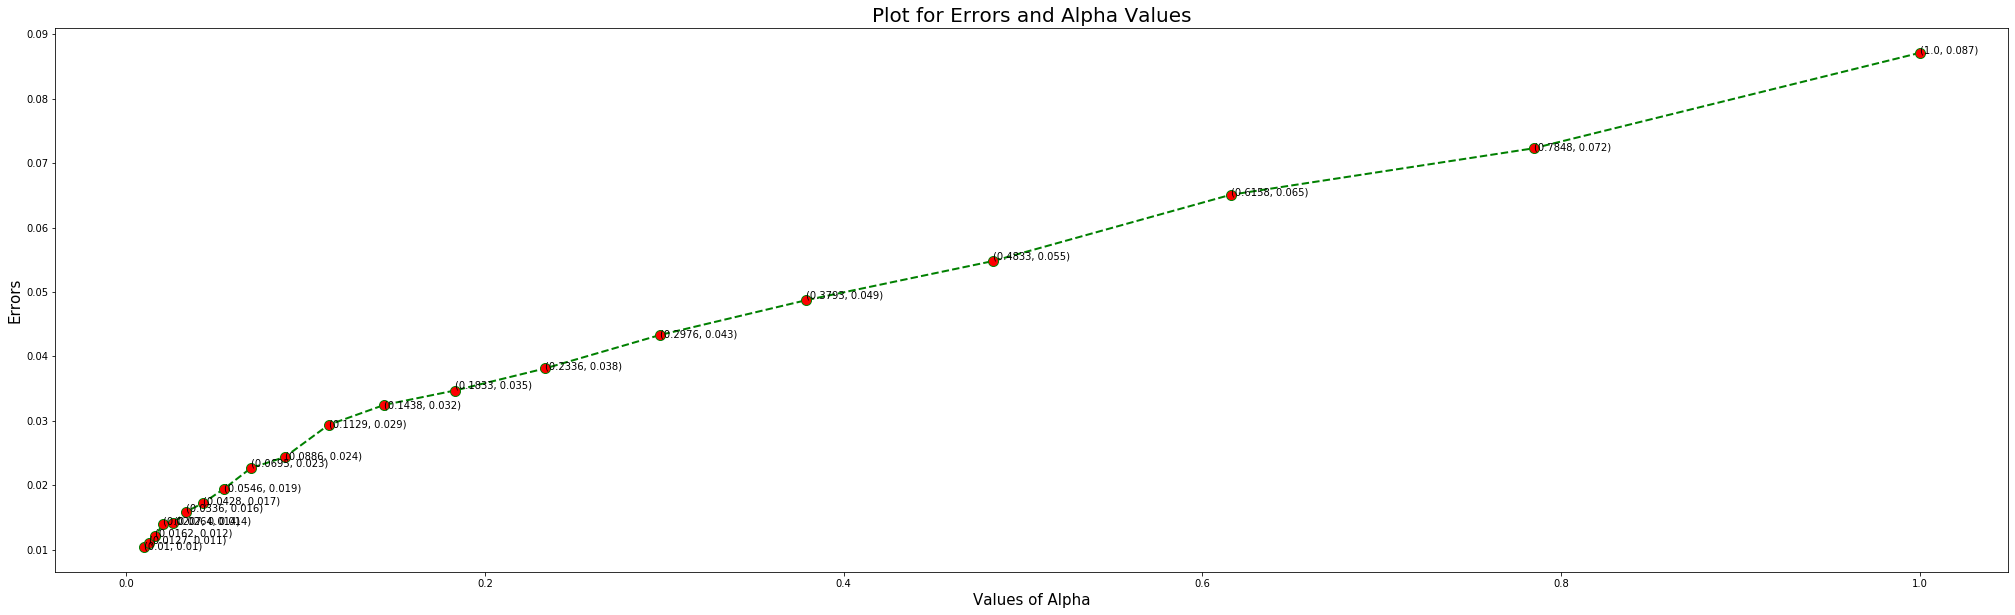

In [5]:
print("Starting Cross Validation steps...")
gsearch_cv = get_GridSearchCV_estimator("Naive Bayes", X_train, y_train, X_test, y_test)
optimal_alpha, mse = plot_errors(gsearch_cv)

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~ PERFORMANCE EVALUATION ~~~~~~~~~~~~~~~~~~~~~~~~
Detailed report for the Naive Bayes algorithm
The number of accurate predictions out of 912 data points on unseen data is 905
Accuracy of the Naive Bayes model on unseen data is 99.23
Precision of the Naive Bayes model on unseen data is 0.9923
Recall of the Naive Bayes model on unseen data is 0.9917
F1 score of the Naive Bayes model on unseen data is 0.9919

Classification report for Naive Bayes model: 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       127
           1       1.00      1.00      1.00       124
           2       1.00      0.99      1.00       112
           3       0.99      1.00      1.00       114
           4       0.99      1.00      1.00       110
           5       0.98      1.00      0.99       116
           6       0.98      1.00      0.99  

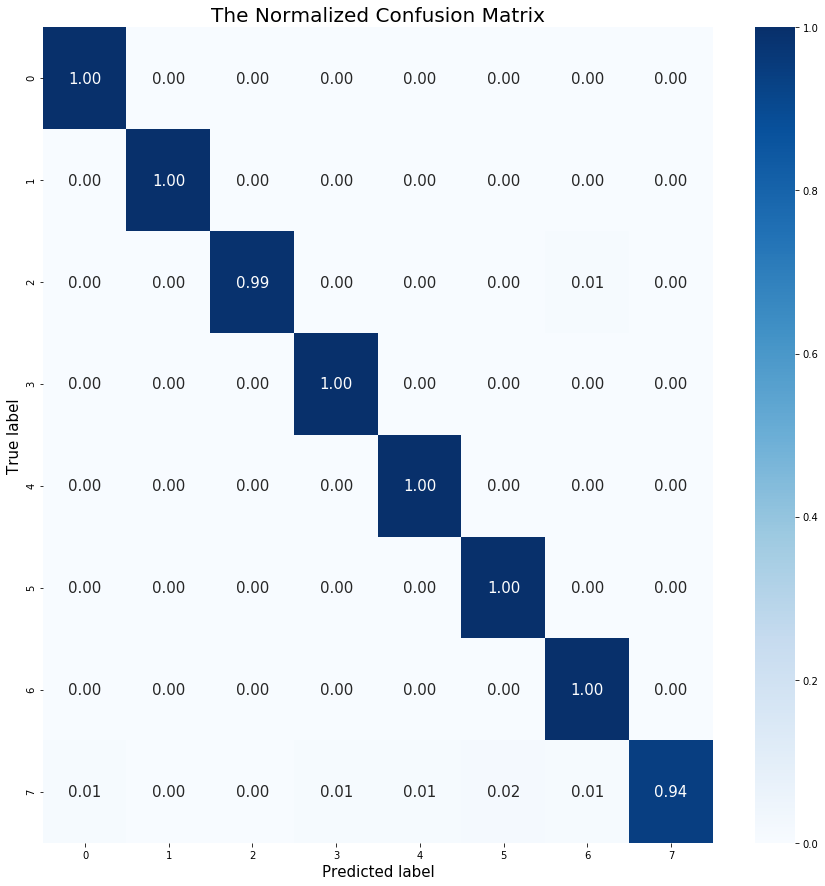


ROC curve and AUC


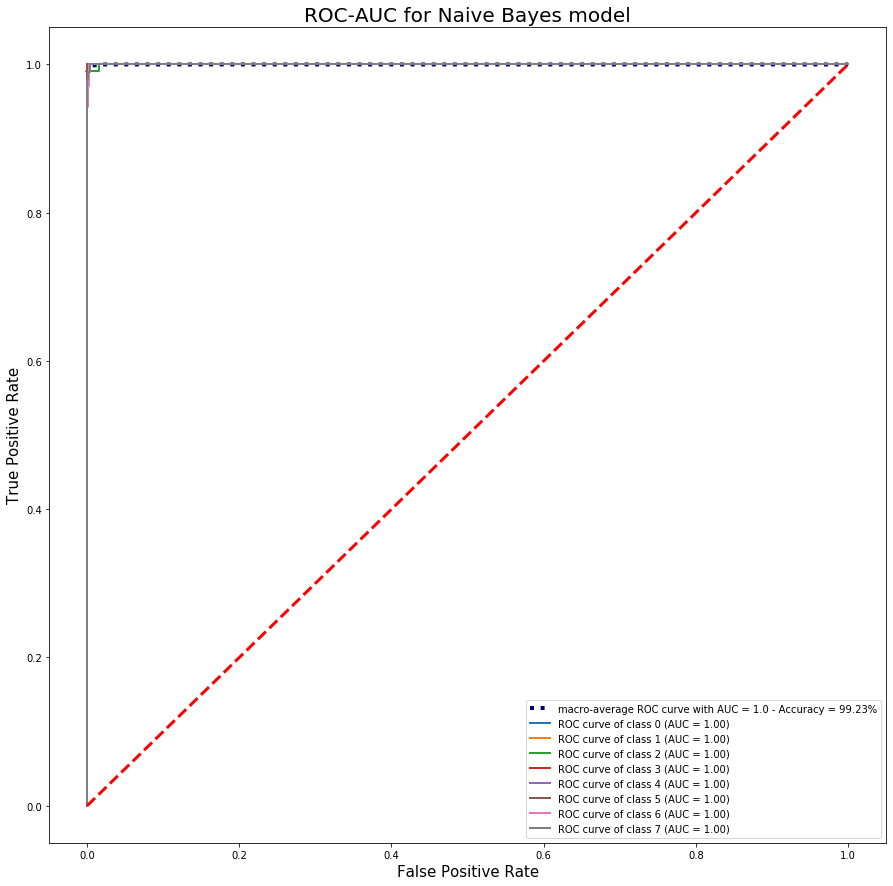

In [6]:
nb_classifier = gsearch_cv.best_estimator_
nb_classifier_train = nb_classifier.fit(X_train, y_train)
y_pred, y_pred_prob = evaluate_multiclass(nb_classifier, X_train, y_train, X_test, y_test, 
                        model="Naive Bayes", num_class=8)

In [7]:
import json
import joblib

joblib.dump(nb_classifier_train, "./nb_classifier.joblib", compress=True)

['./nb_classifier.joblib']